# M5 - calculating 'out_of_stock' feature 640x faster

The is notebook builds 'out_of_stock' feature 80x faster thanks to [math guys here](https://math.stackexchange.com/questions/364038/expected-number-of-coin-tosses-to-get-five-consecutive-heads/1030482#1030482)

In the [previous notebook](https://www.kaggle.com/sibmike/m5-out-of-stock-feature/), I layed out how **we can distinguish between zero demand and zero supply**. Unfortunately, it would take roughly 90 hours to calulate the feature with the help of simulations. This notebook calculates the feature in less then ~~an hour~~ 8 minutes because instead of using simulations we can use a formula to calculate **expected number of days to randomly get a gap of length N** (in other words N consecutive days with zero sales). 

Our gap problem is similar to **"Expected Number of Coin Tosses to Get Five Consecutive Heads"** problem which is discussed and solved [here](https://math.stackexchange.com/a/1834771). The remaining logic is the same: 
1. assume probability of sale on a day, p0 = sale_days/total_days
2. for gap of length N find expected number of days to get it randomly E0 = E(N,p0)
3. mark it as supply_gap if E0/365 > 100 (i.e. it takes **more than 100 years to observe the gap ranomly**)
4. cut out supply_gaps from probability calculations: p1 = (sale_days-supply_gap_days)/(total_days-supply_gap_days)
5. run recursively till p1 stops decreasing

Once in 100 years might be a little conservative threshold, so you can easily change this parameter to your taste. Formula for p1 can also be adjusted. Instead of constructing a boolean feature I have mapped gap days to E/total_days value and saved p value in a separate column. Have fun!

PS: As you will see in the end even with the 100 years threshold, **non random gaps account for over 23% of the dataset**. (That is if I have not messed up somewhere;)

**_PPS: Special thanks to @nadare for outstanding 8x booster that cut time from 1 hr to under 8 mins!_**

In [1]:
# General imports
import numpy as np
import pandas as pd
import os, sys, gc, time, warnings, pickle, psutil, random
from tqdm import tqdm

import seaborn as sns # data visualization library  
import matplotlib.pyplot as plt

warnings.filterwarnings('ignore')

In [2]:
# Load data
grid_df = pd.read_pickle('/kaggle/input/m5-simple-fe/grid_part_1.pkl')
grid_df.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d,sales,release
0,HOBBIES_1_008_CA_1_validation,HOBBIES_1_008,HOBBIES_1,HOBBIES,CA_1,CA,1,12.0,0
1,HOBBIES_1_009_CA_1_validation,HOBBIES_1_009,HOBBIES_1,HOBBIES,CA_1,CA,1,2.0,0
2,HOBBIES_1_010_CA_1_validation,HOBBIES_1_010,HOBBIES_1,HOBBIES,CA_1,CA,1,0.0,0
3,HOBBIES_1_012_CA_1_validation,HOBBIES_1_012,HOBBIES_1,HOBBIES,CA_1,CA,1,0.0,0
4,HOBBIES_1_015_CA_1_validation,HOBBIES_1_015,HOBBIES_1,HOBBIES,CA_1,CA,1,4.0,0


In [3]:
def gap_finder(ts):
    
    # this function finds gaps and calculates their length:
    # note ts: 0 = day with sales, 1 = days with 0 sales
    
    for i, gap in enumerate(ts):
        if gap == 0: 
            continue
        elif i!=0: 
            ts[i] += ts[i-1]
            if ts[i-1]!=0: ts[i-1] = -1
    return ts

In [4]:
# Note: in 'gap' column: 1 is a day without sales:
grid_df['gaps'] = (~(grid_df['sales'] > 0)).astype(int)
total_days = 1941

prods = list(grid_df.id.unique())
s_list = [] #list to hold gaps in days
e_list = [] #list to hold expected values of gaps
p_list = [] #list to hold avg probability of no sales

# original 1 hour version
#for prod_id in tqdm(prods):
#    
#    # extract gap_series for a prod_id
#    m = grid_df.id==prod_id
#    sales_gaps = grid_df.loc[m,'gaps']
#    
#    # calculate initial probability
#    zero_days = sum(sales_gaps)
#    p = zero_days/total_days
#    
#    # find and mark gaps
#    sales_gaps[:] = gap_finder(sales_gaps.values.copy())
#    sales_gaps = sales_gaps.astype(int).replace(-1,np.nan).fillna(method='backfill').fillna(method='ffill')
#    s_list += [sales_gaps]

# magic x8 speed booster thanks to @nadare
for prod_id, df in tqdm(grid_df.groupby("id")):   
    # extract gap_series for a prod_id
    sales_gaps = df.loc[:,'gaps']

    # calculate initial probability
    zero_days = sum(sales_gaps)
    p = zero_days/total_days

    # find and mark gaps
    accum_add_prod = np.frompyfunc(lambda x, y: int((x+y)*y), 2, 1)
    sales_gaps[:] = accum_add_prod.accumulate(df["gaps"], dtype=np.object).astype(int)
    sales_gaps[sales_gaps < sales_gaps.shift(-1)] = np.NaN
    sales_gaps = sales_gaps.fillna(method="bfill").fillna(method='ffill')
    s_list += [sales_gaps]
    
    # calculate E/total_days for all possible gap lengths:
    gap_length = sales_gaps.unique()
    
    d = {length: ((1-p**length)/(p**length*(1-p)))/365 for length in gap_length}
    sales_E_years = sales_gaps.map(d)
    
    # cut out supply_gap days and run recursively
    p1 = 0
    while p1 < p:
        
        if p1!=0:
            p=p1
        
        # once in 100 years event; change to your taste here
        gap_days = sum(sales_E_years>100)
            
        p1 = (zero_days-gap_days+0.0001)/(total_days-gap_days)
        
        d = {length: ((1-p1**length)/(p1**length*(1-p1)))/365 for length in gap_length}
        sales_E_years = sales_gaps.map(d)
        
    # add results to list it turns out masked replacemnt is a very expensive operation in pandas, so better do it in one go
    e_list += [sales_E_years]
    p_list += [pd.Series(p,index=sales_gaps.index)]

100%|██████████| 30490/30490 [07:50<00:00, 64.76it/s]


In [5]:
# add it to grid_df in one go fast!:
grid_df['gap_days'] = pd.concat(s_list)
grid_df['gap_e'] = pd.concat(e_list)
grid_df['sale_prob'] = pd.concat(p_list)
##45664
# Dump to pickle:
grid_df.to_pickle('grid_part_1_gaps.pkl')

In [6]:
# becuase we have some really extreme values lets take a log:
grid_df['gap_e_log10'] = np.log10((grid_df['gap_e'].values+1))

In [7]:
# e over 100 years does not make much sense
m = grid_df['gap_e_log10']>2
grid_df.loc[m,'gap_e_log10']=2

# take a subsample to vizualise:
np.random.seed(19)
depts = list(grid_df.dept_id.unique())

prod_list = []
for d in depts:
    prod_by_dept=grid_df['item_id'][grid_df.dept_id == d].unique()
    prod_list += list(np.random.choice(prod_by_dept,5))
    
m = grid_df.item_id.isin(prod_list)
viz_df = grid_df[m]
viz_df.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d,sales,release,gaps,gap_days,gap_e,sale_prob,gap_e_log10
19,HOBBIES_1_063_CA_1_validation,HOBBIES_1_063,HOBBIES_1,HOBBIES,CA_1,CA,1,0.0,0,1,5.0,0.023456,0.843895,0.010069
93,HOBBIES_1_278_CA_1_validation,HOBBIES_1_278,HOBBIES_1,HOBBIES,CA_1,CA,1,0.0,0,1,1.0,0.011118,0.246416,0.004802
110,HOBBIES_1_312_CA_1_validation,HOBBIES_1_312,HOBBIES_1,HOBBIES,CA_1,CA,1,5.0,0,0,0.0,0.000000,0.256541,0.000000
183,HOBBIES_2_098_CA_1_validation,HOBBIES_2_098,HOBBIES_2,HOBBIES,CA_1,CA,1,1.0,0,0,13.0,0.193890,0.816260,0.076964
557,HOUSEHOLD_2_465_CA_1_validation,HOUSEHOLD_2_465,HOUSEHOLD_2,HOUSEHOLD,CA_1,CA,1,0.0,0,1,1.0,0.007221,0.379423,0.003125


### mini EDA
As you can see there is a variety of non-random gaps. Large patches when a product disappears from all stores. Gaps when several products disappear. And lots of Store specific supply failures.

In [8]:
v_df = viz_df.pivot(index='d', columns='id', values='gap_e_log10')
v_df = v_df.reindex(sorted(v_df.columns), axis=1)

In [9]:
v_df.describe()

id,FOODS_1_076_CA_1_validation,FOODS_1_076_CA_2_validation,FOODS_1_076_CA_3_validation,FOODS_1_076_CA_4_validation,FOODS_1_076_TX_1_validation,FOODS_1_076_TX_2_validation,FOODS_1_076_TX_3_validation,FOODS_1_076_WI_1_validation,FOODS_1_076_WI_2_validation,FOODS_1_076_WI_3_validation,...,HOUSEHOLD_2_470_CA_1_validation,HOUSEHOLD_2_470_CA_2_validation,HOUSEHOLD_2_470_CA_3_validation,HOUSEHOLD_2_470_CA_4_validation,HOUSEHOLD_2_470_TX_1_validation,HOUSEHOLD_2_470_TX_2_validation,HOUSEHOLD_2_470_TX_3_validation,HOUSEHOLD_2_470_WI_1_validation,HOUSEHOLD_2_470_WI_2_validation,HOUSEHOLD_2_470_WI_3_validation
count,1941.000000,1941.000000,1941.000000,1941.000000,1941.000000,1941.000000,1941.000000,1934.000000,1941.000000,1906.000000,...,1941.000000,1815.000000,1941.000000,1941.000000,1941.000000,1941.000000,1941.000000,1941.000000,1934.000000,1941.000000
mean,0.081483,0.062776,0.068177,0.495216,0.210562,0.155287,0.587307,0.488948,0.355353,0.457259,...,0.294840,0.090431,0.187988,0.137012,0.376060,0.062580,0.313304,0.128184,0.736796,0.247753
std,0.291545,0.266147,0.282759,0.822114,0.548702,0.498693,0.883175,0.787025,0.668354,0.728765,...,0.674345,0.355709,0.541549,0.460825,0.736039,0.298477,0.701793,0.435516,0.903129,0.605330
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.006681,0.014736,0.015445,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.004660,0.000000
50%,0.007112,0.002956,0.002908,0.008655,0.007226,0.000000,0.003443,0.022792,0.037319,0.076523,...,0.003762,0.003675,0.000000,0.002636,0.002771,0.000000,0.004125,0.002546,0.063021,0.002609
75%,0.016449,0.010238,0.009955,0.633523,0.035653,0.004796,2.000000,0.843689,0.215453,0.386640,...,0.050774,0.014882,0.005292,0.021052,0.123376,0.004297,0.018195,0.019358,2.000000,0.046288
max,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,...,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000


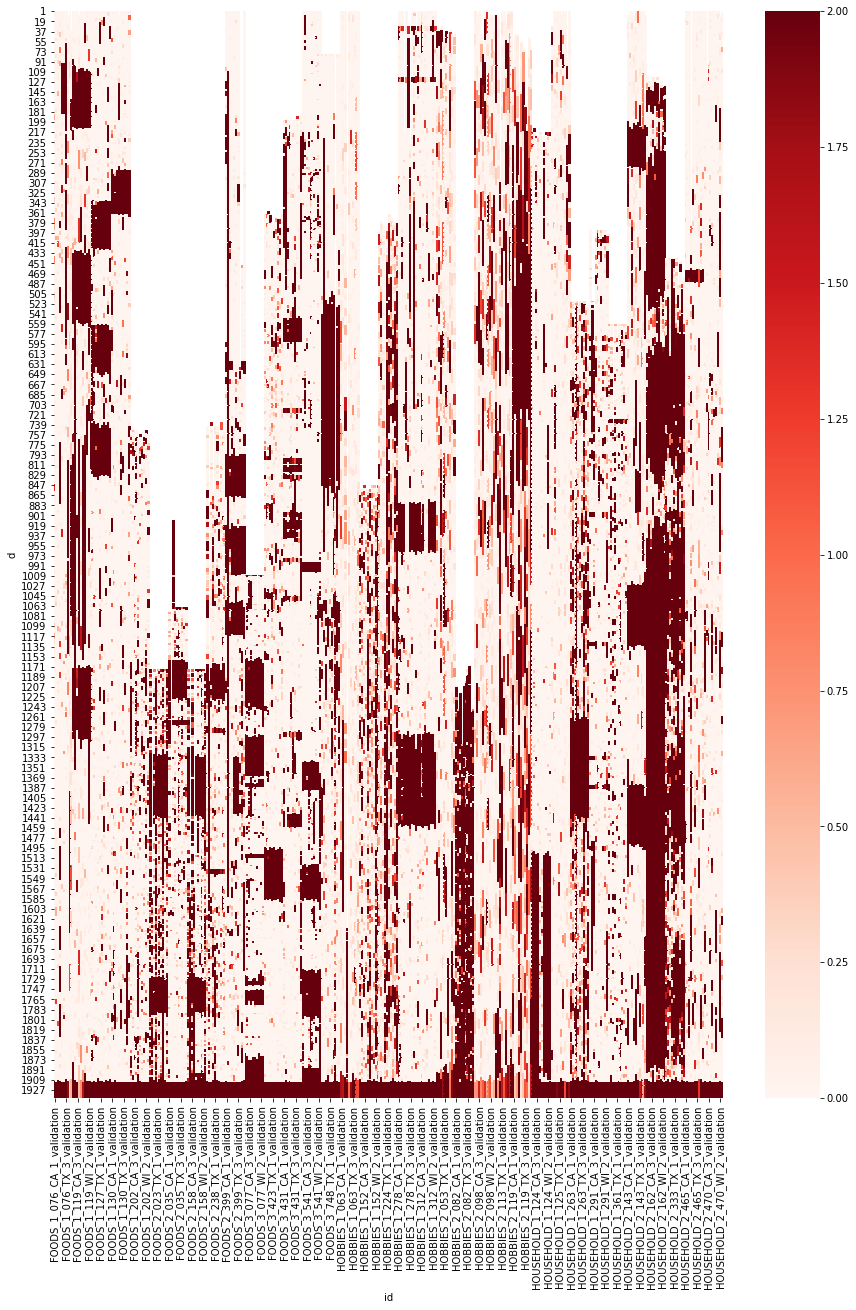

In [10]:
f, ax = plt.subplots(figsize=(15, 20))
temp = sns.heatmap(v_df, cmap='Reds')
plt.show()

In [11]:
grid_df.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d,sales,release,gaps,gap_days,gap_e,sale_prob,gap_e_log10
0,HOBBIES_1_008_CA_1_validation,HOBBIES_1_008,HOBBIES_1,HOBBIES,CA_1,CA,1,12.0,0,0,0.0,0.000000,0.133878,0.000000
1,HOBBIES_1_009_CA_1_validation,HOBBIES_1_009,HOBBIES_1,HOBBIES,CA_1,CA,1,2.0,0,0,1.0,0.005738,0.477435,0.002485
2,HOBBIES_1_010_CA_1_validation,HOBBIES_1_010,HOBBIES_1,HOBBIES,CA_1,CA,1,0.0,0,1,2.0,0.017981,0.473896,0.007740
3,HOBBIES_1_012_CA_1_validation,HOBBIES_1_012,HOBBIES_1,HOBBIES,CA_1,CA,1,0.0,0,1,1.0,0.004060,0.674823,0.001760
4,HOBBIES_1_015_CA_1_validation,HOBBIES_1_015,HOBBIES_1,HOBBIES,CA_1,CA,1,4.0,0,0,2.0,0.129886,0.156164,0.053035


In [12]:
#Finally lets calculate the proportion of non random gaps in original dataset.
# as mentioned by @Amphi2 we should have dropped last 28 days, so lets substract them:

(sum(grid_df['gap_e_log10'] >= 2) - 3049*10*28)/grid_df.shape[0]

0.21870363127155198

 [Discussion here.](https://www.kaggle.com/c/m5-forecasting-accuracy/discussion/138085#790628)